In [1]:
import librosa
from ipywidgets import Audio
import IPython.display
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import numpy as np
import scipy
import matplotlib.pyplot as plt
import soundfile as sf
import torch
from tqdm.notebook import tqdm
from functools import partial

from gfm_iaif import gfm_iaif
from utils import h1h2, weighted_log_mag_mse_loss
from tract_proxy import VocalTractProxy
from optimize import TractControlsOptimizer
from glottis import Glottis

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
input, fs = librosa.load("0_47.wav")
Audio.from_file("0_47.wav", loop=False)

Audio(value=b'RIFF2\xd7\n\x00WAVEfmt \x12\x00\x00\x00\x03\x00\x01\x00\x80\xbb\x00\x00\x00\xee\x02\x00\x04\x00 …

In [4]:
framelength = 1024
hoplength = 128
fmin, fmax = 70, 500
ncilinders = 44

In [5]:
frames = librosa.util.frame(input, frame_length=framelength, hop_length=hoplength)
nframes = frames.shape[1]

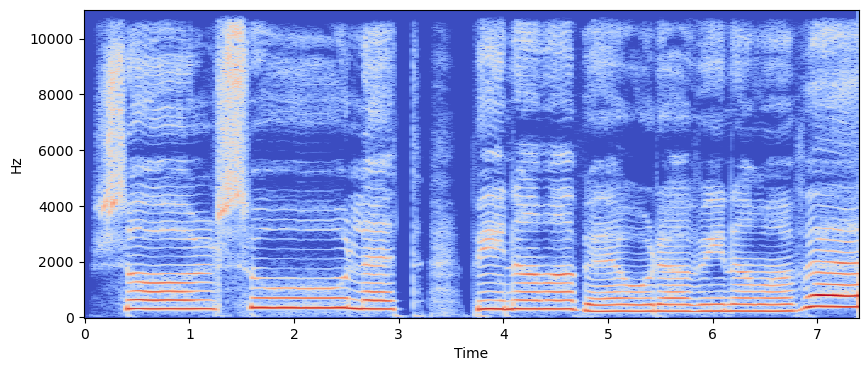

In [6]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(input, n_fft=framelength))).squeeze()
plt.figure(figsize=(10,4))
librosa.display.specshow(X, sr=fs, x_axis="time", y_axis="hz")

## Analysis

### Pitch

- Yin
- `trough_threshold` defaults to $0.01$ but $0.1$ works better, or even $1$
- regions with with very low volume seem to work bad (chirp in result)

In [7]:
f0 = np.concatenate([librosa.yin(frames[:,i] / np.max(np.abs(frames[:,i])), fmin=fmin, fmax=fmax, frame_length=framelength, hop_length=hoplength, sr=fs, center=False, trough_threshold=0.1) for i in range(nframes)])
plot = figure(title="Estimated f0", x_axis_label="Frame", y_axis_label="Frequency (Hz)", width=800, height=400)
plot.line(np.arange(f0.size), f0)
show(plot)

When auto correlation is close to 0 (due to no signal, just noise), pitch goes crazy.

In [8]:
acorr = np.stack([np.max(librosa.autocorrelate(frames[:,i])) for i in range(nframes)])
plot = figure(title="Auto correlation", width=800, height=400, x_axis_label="Frame", y_axis_label="Correlation")
plot.line(np.arange(nframes), acorr)
show(plot)

### Inverse filtering with GFM-IAIF

In [9]:
glottis = np.zeros_like(input)
vtcoeffs = np.empty((ncilinders+1,nframes))
glcoeffs = np.empty((4, nframes))
lipcoeffs = np.empty((2, nframes))

for i in range(nframes):
    frame = frames[:, i]
    vtcoeffs[:,i], glcoeffs[:,i], lipcoeffs[:,i] = gfm_iaif(frame, n_vt=ncilinders)
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    glottis[idx] += scipy.signal.lfilter(vtcoeffs[:,i], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)

IPython.display.Audio(data=glottis.T.flatten(), rate=fs)

In [10]:
sf.write("glottis.wav", glottis, fs, subtype="PCM_16")

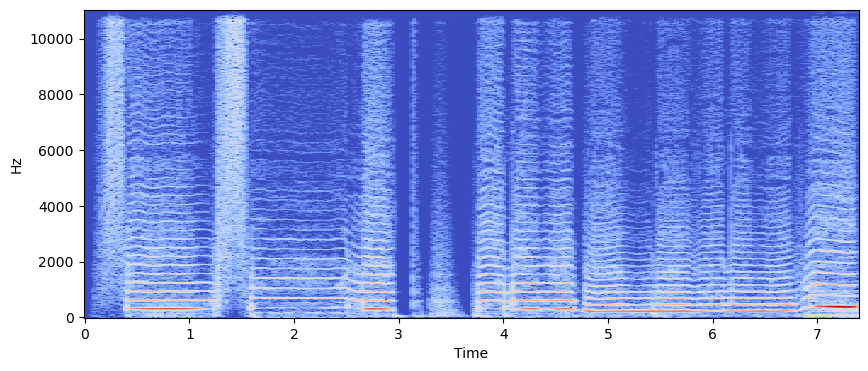

In [10]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(glottis, n_fft=framelength))).squeeze()
plt.figure(figsize=(10,4))
librosa.display.specshow(X, sr=fs, x_axis="time", y_axis="hz")

In [11]:
gframes = librosa.util.frame(glottis, frame_length=framelength, hop_length=hoplength)

### Tenseness

In [26]:
# Rd = torch.tensor((h1h2(gframes, f0, sr=fs) + 7.6) / 11.1)
Rd = np.empty(nframes)

for i in range(nframes):
    X = librosa.amplitude_to_db(np.abs(librosa.stft(gframes[:,i], n_fft=framelength, hop_length=framelength)))
    h1bin = int(np.round(f0[i] / fs * framelength))
    h2bin = int(np.round(2 * f0[i] / fs * framelength))
    Rd[i] = (X[h1bin,1] - X[h2bin,1] + 7.6) / 11.

plot = figure(title="Rd", width=800, height=400, x_axis_label="Frame")
plot.line(np.arange(nframes), Rd)
show(plot)

In [27]:
tenseness = np.clip(1 - Rd / 3, 0, 1)
plot = figure(title="Tenseness", width=800, height=400, x_axis_label="Frame")
plot.line(np.arange(nframes), tenseness)
show(plot)

In [28]:
glottis = Glottis(ncilinders, fs)
out = glottis.get_waveform(tenseness=torch.Tensor(tenseness), freq=torch.Tensor(f0.reshape(-1, 1)), frame_len=hoplength).detach().numpy()
IPython.display.Audio(data=out, rate=fs, autoplay=True)

In [35]:
sf.write("glottis-synth.wav", out, fs, subtype="PCM_16")

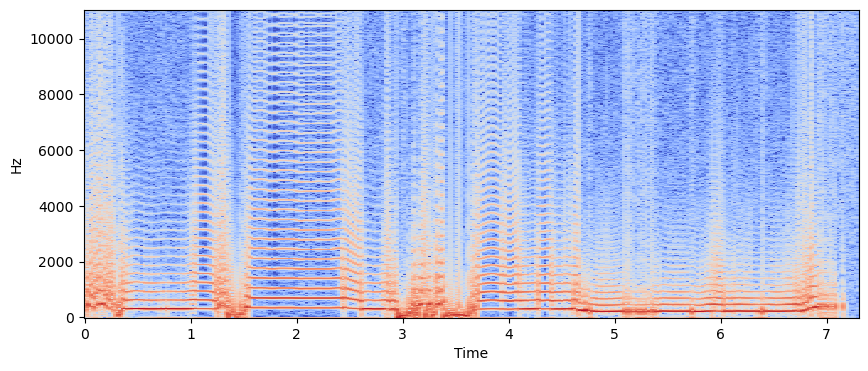

In [29]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(out, n_fft=framelength))).squeeze()
plt.figure(figsize=(10,4))
librosa.display.specshow(X, sr=fs, x_axis="time", y_axis="hz")